# Transfer Learning using VGG-16

Here we will attempt to use transfer learning to learn a feature embedding. We will use the following model: VGG-16 (as per the paper Automating Morphological Profiling with Generic Deep Convolutional Networks).

In [6]:
import os
import numpy as np
from tensorflow import keras
import keras.preprocessing
from keras.applications import VGG16
import keras.applications.vgg16
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
pathToAllPatches = "allGoodCellPatchesWithNoBackgroundInfo/"

VGG 16 without the last layer.

In [8]:
modelVGG16 = VGG16(weights='imagenet', include_top=False)

In [9]:
def loadPreprocessImagesVGG16(folderPath, model):
    images = []
    num_images = len(os.listdir(folderPath))
    for idx in range(num_images):
        imgPath = folderPath + str(idx) + ".png"
        img = keras.preprocessing.image.load_img(imgPath, target_size=(224, 224))
        imgArray = keras.preprocessing.image.img_to_array(img)
        imgArray = np.expand_dims(imgArray, axis=0)
        imgArray = keras.applications.vgg16.preprocess_input(imgArray)
        images.append(imgArray)

    images = np.vstack(images)
    features = model.predict(images)
    return features

In [10]:
features = loadPreprocessImagesVGG16(pathToAllPatches, modelVGG16)

49/49 [==============================] - 303s 6s/step


In [11]:
# Reshape the features to fit into PCA, note VGG 16 has a feature map size of 7x7x512
nsamples, nx, ny, nz = features.shape
featuresReshaped = features.reshape((nsamples, nx*ny*nz))

In [12]:
pca = PCA()
principalComponents = pca.fit(featuresReshaped)

# Calculate cumulative explained variance
cumulativeExplainedVariance = pca.explained_variance_ratio_.cumsum()

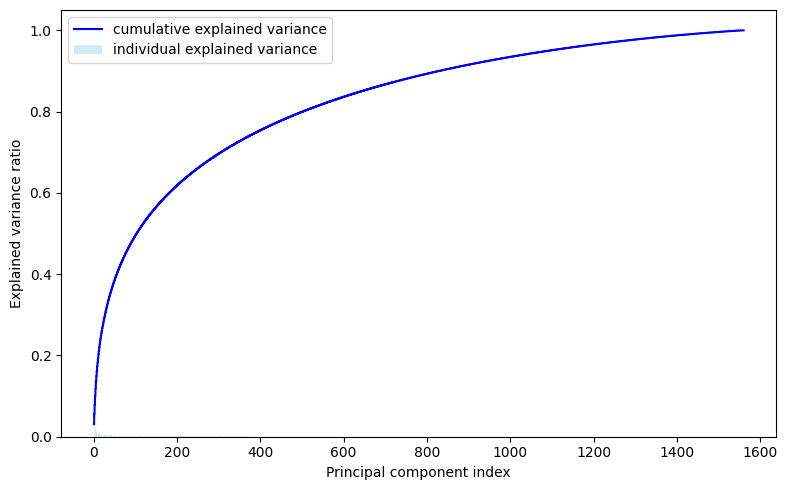

In [13]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center',
        label='individual explained variance', color='lightblue')
plt.step(range(1, len(cumulativeExplainedVariance) + 1), cumulativeExplainedVariance, where='mid',
         label='cumulative explained variance', color='blue')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

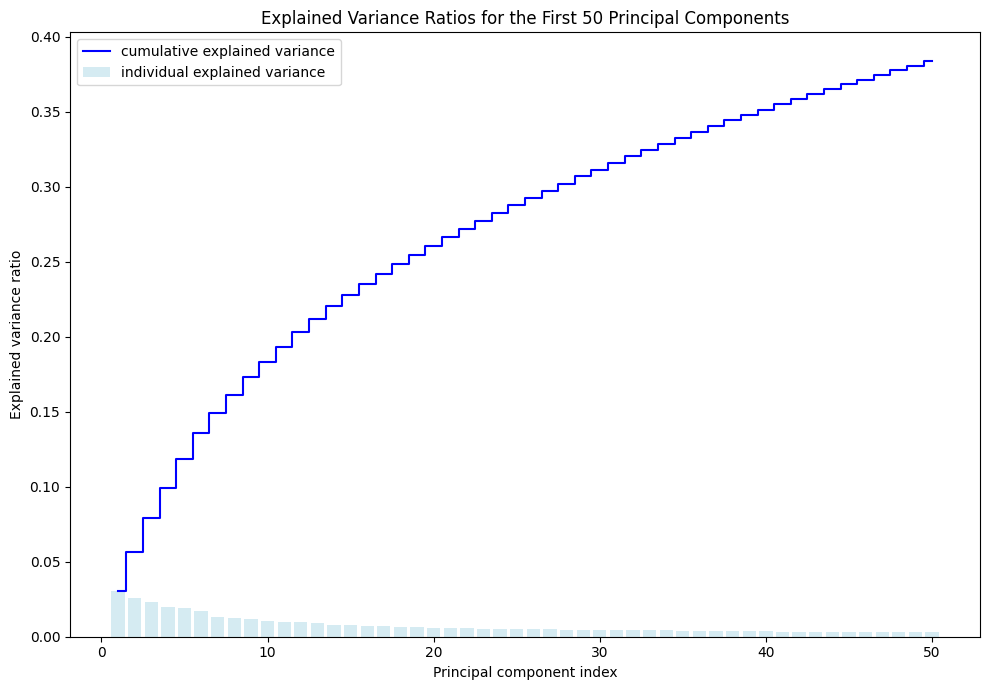

In [14]:
# Number of components to display
numComponents = 50

# Create the plot
plt.figure(figsize=(10, 7))
plt.bar(range(1, numComponents + 1), pca.explained_variance_ratio_[:numComponents], alpha=0.5, align='center',
        label='individual explained variance', color='lightblue')
plt.step(range(1, numComponents + 1), cumulativeExplainedVariance[:numComponents], where='mid',
         label='cumulative explained variance', color='blue')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance Ratios for the First 50 Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We find the number of components that explain over 80% of the variance.

In [15]:
# Find the number of components that explain at least 80% of the variance
n_components = np.where(cumulativeExplainedVariance >= 0.8)[0][0] + 1

In [16]:
n_components

502

In [17]:
# Initialize PCA with the number of components determined
pca_reduced = PCA(n_components=n_components)
principalComponents_reduced = pca_reduced.fit_transform(featuresReshaped)

We determine the optimal number of clusters. Start by using elbow method.

c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

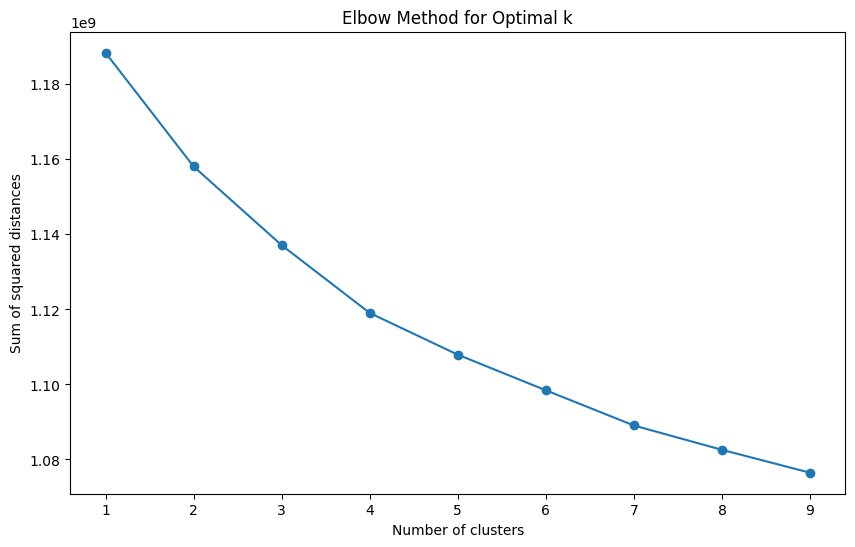

In [19]:
# Determine the range of clusters to try
k_range = range(1, 10)
sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principalComponents_reduced)
    sse.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

We also use silhouette analysis.

c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

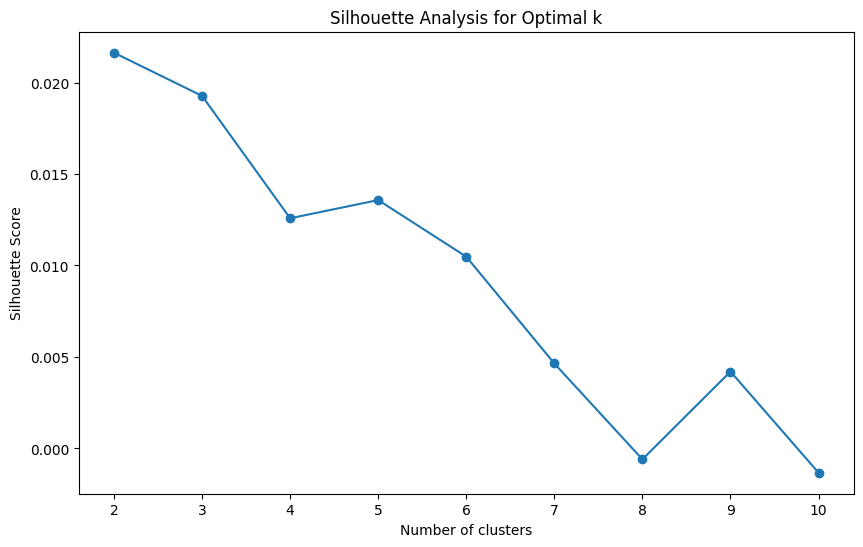

In [21]:
k_range = range(2, 11)  # Start from 2 as silhouette score cannot be calculated for k=1
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(principalComponents_reduced)
    score = silhouette_score(principalComponents_reduced, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

We apply the optimal cluster that we get from the silhouette analysis.

In [23]:
k_optimal = k_range[np.argmax(silhouette_scores)]
# Apply K-Means clustering with the optimal number of clusters
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans_final.fit_predict(principalComponents_reduced)

c:\Users\anabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
# Note cluster_labels contain the cluster assignments for each image
# and pathToAllPatches is the directory containing the images.
def sample_images_from_clusters(cluster_labels, num_samples_per_cluster, path):
    cluster_dict = {}
    # Create a dictionary to hold indices for each cluster
    for index, label in enumerate(cluster_labels):
        if label not in cluster_dict:
            cluster_dict[label] = []
        cluster_dict[label].append(index)
    
    # Sample images from each cluster
    sampled_indices = {cluster: np.random.choice(indices, num_samples_per_cluster, replace=False)
                       for cluster, indices in cluster_dict.items() if len(indices) >= num_samples_per_cluster}

    # Load and plot the sampled images
    for cluster, indices in sampled_indices.items():
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            img_path = os.path.join(path, f"{idx}.png")
            img = Image.open(img_path)
            plt.subplot(1, num_samples_per_cluster, i + 1)
            plt.imshow(img)
            plt.title(f"Cluster {cluster} Image {idx}")
            plt.axis('off')
        plt.show()

def sample_images_from_clustersv2(cluster_labels, num_samples_per_cluster, path):
    cluster_dict = {}
    # Create a dictionary to hold indices for each cluster
    for index, label in enumerate(cluster_labels):
        if label not in cluster_dict:
            cluster_dict[label] = []
        cluster_dict[label].append(index)
    
    # Sample images from each cluster
    sampled_indices = {cluster: np.random.choice(indices, num_samples_per_cluster, replace=False)
                       for cluster, indices in cluster_dict.items() if len(indices) >= num_samples_per_cluster}

    # Load and plot the sampled images
    for cluster, indices in sampled_indices.items():
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            img_path = os.path.join(path, f"{idx}.png")
            img = Image.open(img_path)
            plt.subplot(1, num_samples_per_cluster, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

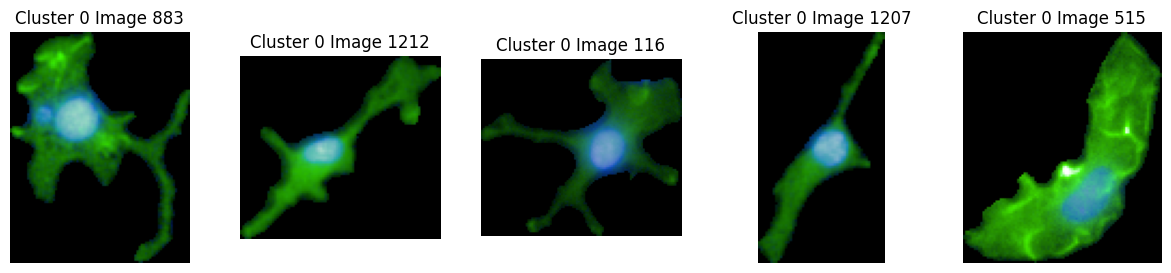

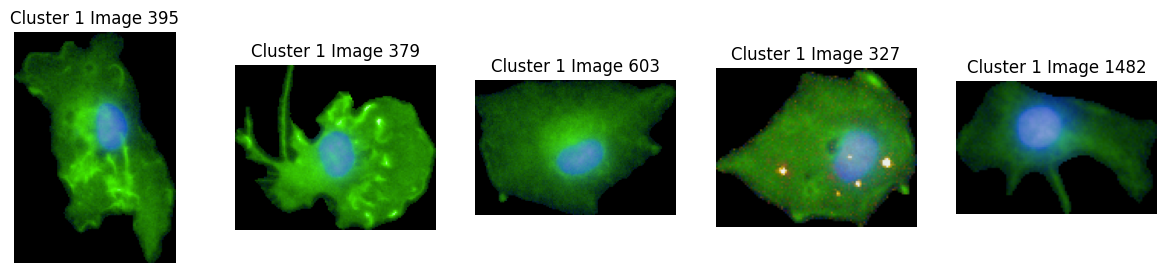

In [27]:
sample_images_from_clusters(cluster_labels, num_samples_per_cluster=5, path=pathToAllPatches)

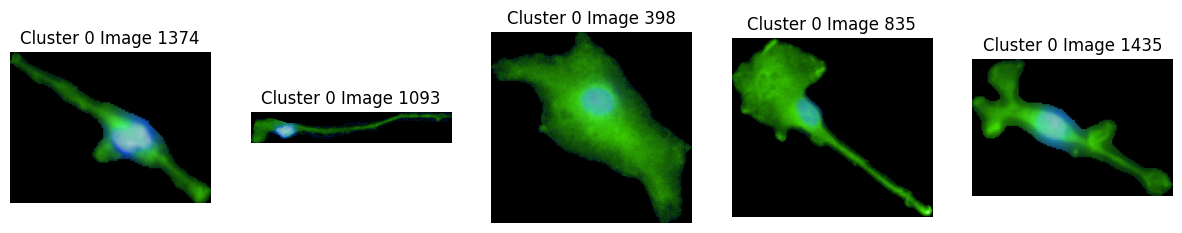

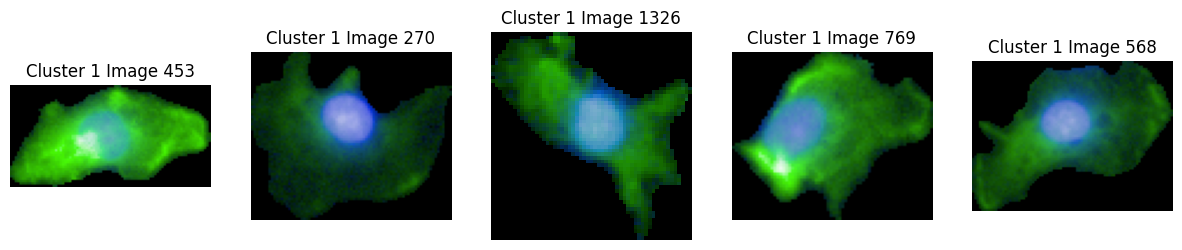

In [30]:
sample_images_from_clusters(cluster_labels, num_samples_per_cluster=5, path=pathToAllPatches)

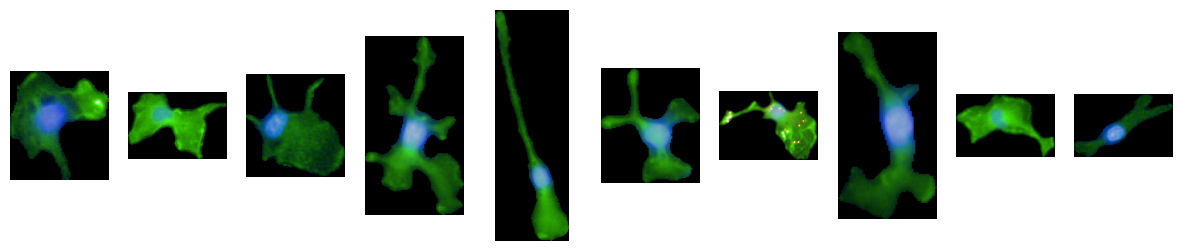

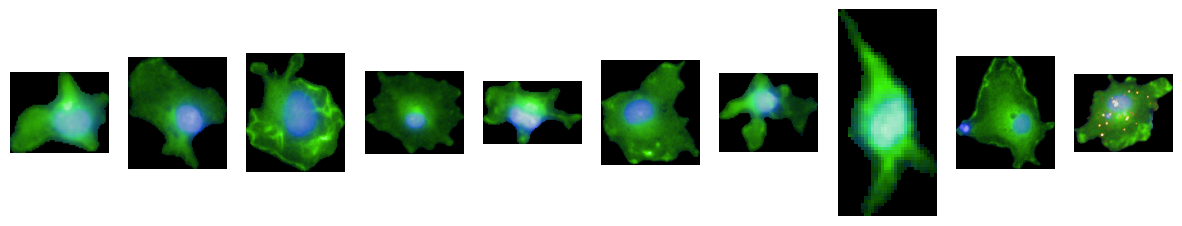

In [34]:
sample_images_from_clustersv2(cluster_labels, num_samples_per_cluster=10, path=pathToAllPatches)